# r-3366

Taken on March 19th, Krypton run, Krypton trigger with "November 20162 conditions

In [1]:
import datetime

In [2]:
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-03-21 11:45:38


In [3]:
from __future__ import print_function
import sys
import os
from glob import glob
from time import time

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np
import math


In [5]:
from invisible_cities.database import load_db
import invisible_cities.sierpe.blr as blr
import invisible_cities.core.mpl_functions as mpl
import invisible_cities.reco.wfm_functions as wfm
import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions_c as cpf
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.pmaps_functions as pmf

In [6]:
from invisible_cities.reco.pmap_io import pmap_writer, S12, S2Si

from   invisible_cities.core.configure import configure, print_configuration

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.cities.base_cities import PmapCity, SensorParams
from   invisible_cities.cities.base_cities import S12Params as S12P

In [7]:
from invisible_cities.core.core_functions import define_window
from invisible_cities.core.core_functions import lrange
from collections import namedtuple

In [8]:
from invisible_cities.reco.params import S12Params, ThresholdParams, CalibratedSum, PMaps, RawVectors,\
                                         SensorParams, CalibParams, PmapParams, CalibratedPMT, S1PMaps

In [71]:
from matplotlib.figure import Figure

In [9]:
%load_ext Cython

## Files

In [11]:
RWF_file = os.path.join(os.environ['IC_DATA'],'LSC/3366/dst_waves.gdcsnext.100_3366.root.h5')

In [12]:
h5rwf = False

In [13]:
if h5rwf:
    h5rwf.close()

In [14]:
h5rwf = tb.open_file(RWF_file,'r')

In [15]:
h5rwf

File(filename=/home/icuser/Projects/ICDATA/LSC/3366/dst_waves.gdcsnext.100_3366.root.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/RD (Group) ''
/RD/pmtblr (EArray(167, 12, 52000), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/RD/pmtrwf (EArray(167, 12, 52000), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/RD/sipmrwf (EArray(167, 1792, 1300), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 1300)
/Run (Group) ''
/Run/events (Table(167,)) ''
  description := {
  "evt_number": Int32Col(shape=(), dflt=0, pos=0),
  "timestamp": UInt64Col(shape=(), dflt=0, pos=1)}
  byteorder := 'little'
  chunkshape := (

### pmtrwf and sipmrwf vectors

To get vectors use **get_vectors(file)** in tbl_functions

In [16]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)

In [17]:
NEVT, NPMT, PMTWL = pmtrwf.shape
NEVT, NSIPM, SIPMWL = sipmrwf.shape
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL,NSIPM, SIPMWL))


        Number of events in file = 167
        Number of PMTs = 12
        PMTWL = 52000
        Number of SiPMs = 1792
        SiPMWL = 1300
      


### Access to data base and definition of units

In [18]:
DataPMT = load_db.DataPMT()
adc_to_pes = abs(DataPMT.adc_to_pes.values)
coeff_c = abs(DataPMT.coeff_c.values)
coeff_blr = abs(DataPMT.coeff_blr.values)
DataSiPM = load_db.DataSiPM()
adc_to_pes_sipm = DataSiPM.adc_to_pes.values
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [19]:
def pmt_calib_vectors():
    """Provisional fix for calib vectors"""
    channel_id = np.array([0,1,4,5,8,18,22,23,26,27,31])
    coeff_blr = np.array([1.61,1.62,1.61,1.61,1.61,
                      0.8,0.8,0.8,0.8,0.8,1.60,
                      1.0]) * 0.001
    coeff_c = np.array([2.94,2.75,3.09,2.81,2.88,
                    1.,1.,1.,1.,1.,2.76,
                    1.0]) * 1e-6
    adc_to_pes = np.array([25.17,22.15,33.57,23.88,21.55,
                       26.49,25.39,27.74,23.78,20.83,26.56,
                       0.])
    pmt_active = list(range(11))

    CalibVectors = namedtuple('CalibVectors',
                    'channel_id coeff_blr coeff_c adc_to_pes pmt_active')
    return CalibVectors(channel_id = channel_id,
                        coeff_blr  = coeff_blr,
                        coeff_c    = coeff_c,
                        adc_to_pes = adc_to_pes,
                        pmt_active  = pmt_active)


In [20]:
P = pmt_calib_vectors()

In [21]:
P

CalibVectors(channel_id=array([ 0,  1,  4,  5,  8, 18, 22, 23, 26, 27, 31]), coeff_blr=array([ 0.00161,  0.00162,  0.00161,  0.00161,  0.00161,  0.0008 ,
        0.0008 ,  0.0008 ,  0.0008 ,  0.0008 ,  0.0016 ,  0.001  ]), coeff_c=array([  2.94000000e-06,   2.75000000e-06,   3.09000000e-06,
         2.81000000e-06,   2.88000000e-06,   1.00000000e-06,
         1.00000000e-06,   1.00000000e-06,   1.00000000e-06,
         1.00000000e-06,   2.76000000e-06,   1.00000000e-06]), adc_to_pes=array([ 25.17,  22.15,  33.57,  23.88,  21.55,  26.49,  25.39,  27.74,
        23.78,  20.83,  26.56,   0.  ]), pmt_active=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

### RWF

In [26]:
event=1
RWF = pmtrwf[event]

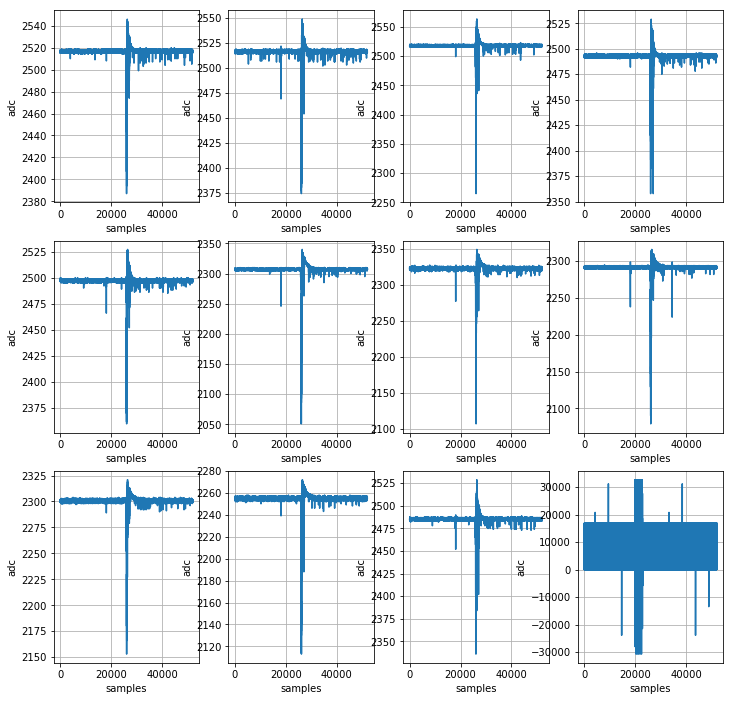

In [27]:
wfm.plot_pmt_waveforms(RWF, zoom=False, window_size=10000)

In [28]:
CWF = blr.deconv_pmt(RWF, P.coeff_c, P.coeff_blr, n_baseline=48000, thr_trigger=5)

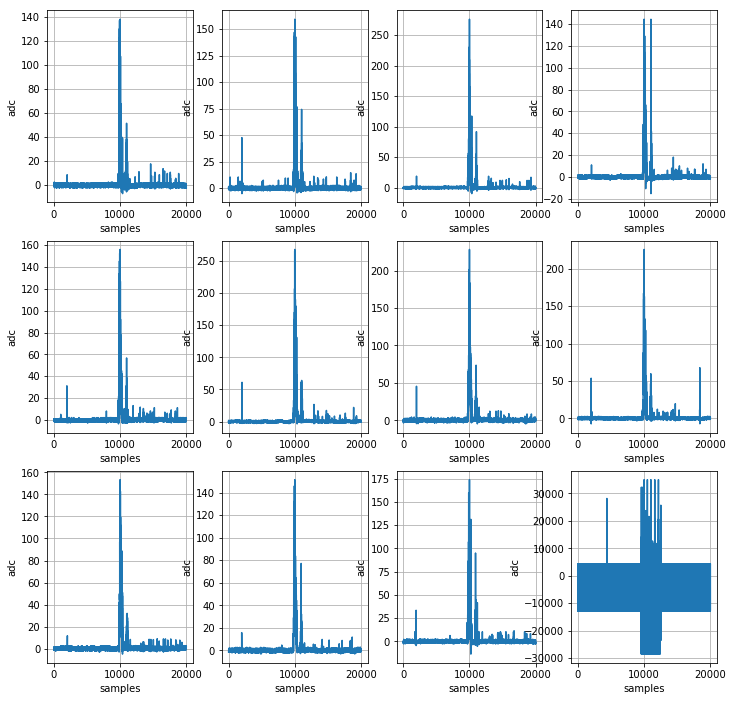

In [29]:
wfm.plot_pmt_waveforms(CWF, zoom=True, window_size=10000)

In [30]:
CAL_PMT, CAL_PMT_MAU    =    cpf.calibrated_pmt_mau(
                               CWF,
                               P.adc_to_pes,
                               pmt_active =P.pmt_active,
                               n_MAU = 100,
                               thr_MAU =  3)

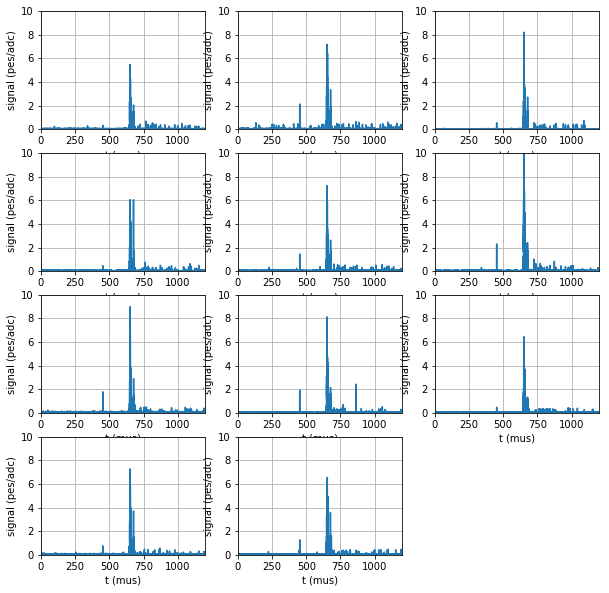

In [31]:
mpl.plot_pmt_signals_vs_time_mus(CAL_PMT,
                             pmt_active = P.pmt_active,
                             t_min      = 0,
                             t_max      = 1200,
                             signal_min =    0,
                             signal_max =  10)

In [32]:
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,P.adc_to_pes,P.pmt_active)

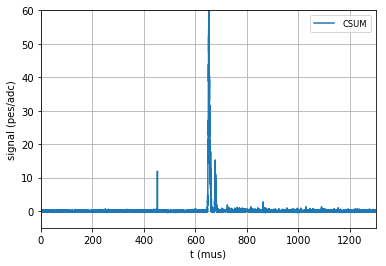

In [33]:
mpl.plot_signal_vs_time_mus(csum, t_min=0, t_max=1300, signal_min=-5, signal_max=60, label='CSUM')

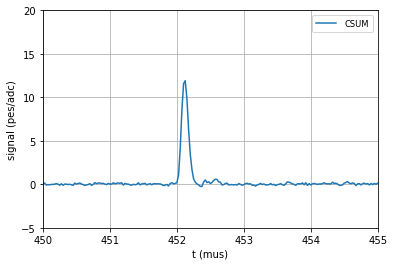

In [36]:
mpl.plot_signal_vs_time_mus(csum, t_min=450, t_max=455, signal_min=-5, signal_max=20, label='CSUM')

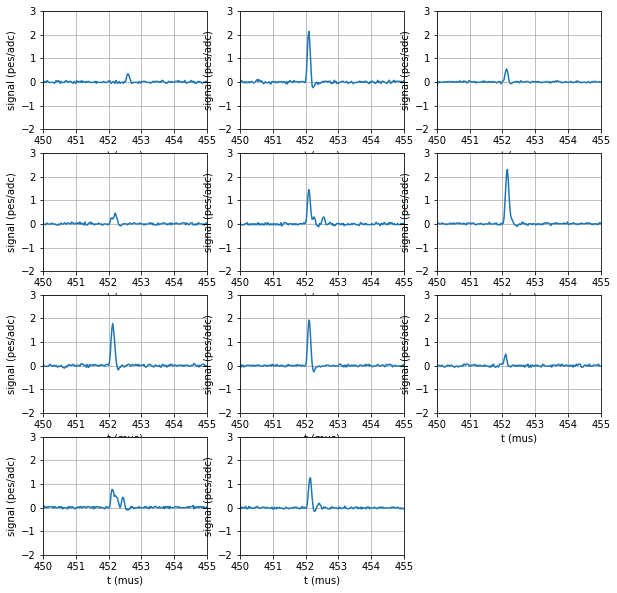

In [37]:
mpl.plot_pmt_signals_vs_time_mus(CAL_PMT,
                             pmt_active = P.pmt_active,
                             t_min      = 450,
                             t_max      = 455,
                             signal_min =    -2,
                             signal_max =  3)

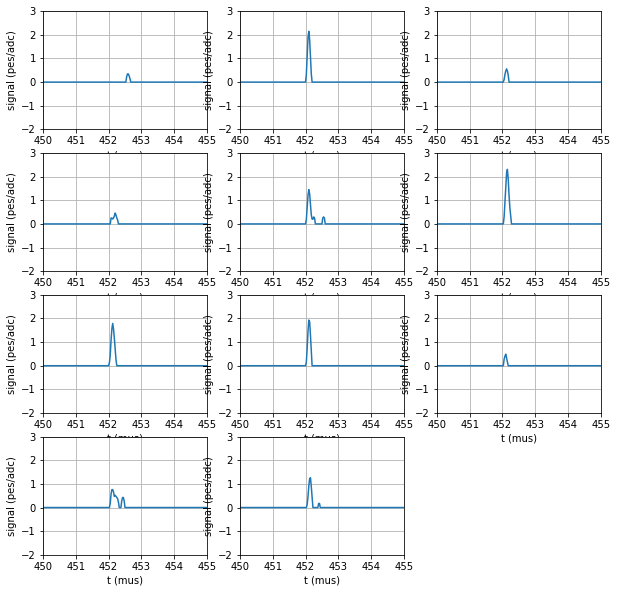

In [39]:
mpl.plot_pmt_signals_vs_time_mus(CAL_PMT_MAU,
                             pmt_active = P.pmt_active,
                             t_min      = 450,
                             t_max      = 455,
                             signal_min =    -2,
                             signal_max =  3)

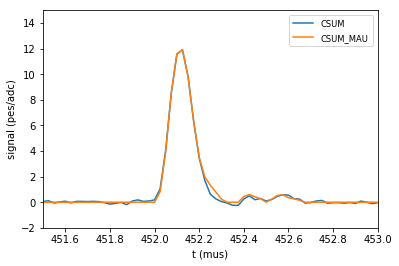

In [42]:
mpl.plot_calibrated_sum_in_mus(CalibratedSum(csum=csum, csum_mau=csum_mau), 
                               tmin=451.5, tmax=453, signal_min=-2, signal_max=15, 
                               csum=True, csum_mau=True)

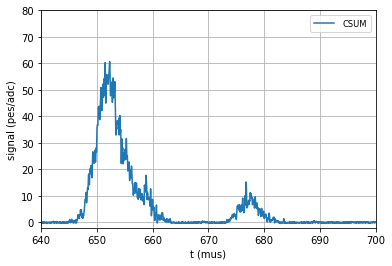

In [44]:
mpl.plot_signal_vs_time_mus(csum, t_min=640, t_max=700, signal_min=-2, signal_max=80, label='CSUM')

### s12 searches

In [55]:
s1par = S12Params(tmin=0*units.mus, tmax=640*units.mus, lmin=6, lmax=30, stride=20, rebin=False)
s1par_PMT = S12Params(tmin=450*units.mus, tmax=455*units.mus, lmin=3, lmax=20, stride=4, rebin=False)

In [56]:
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=0.3)
S1 =  cpf.find_S12(s1_ene, s1_indx, **s1par._asdict())

In [57]:
S1

{0: [array([ 452025.,  452050.,  452075.,  452100.,  452125.,  452150.,
          452175.,  452200.,  452225.,  452250.,  452275.,  452400.,
          452425.,  452450.,  452550.,  452575.,  452600.]),
  array([  0.82525518,   3.94772347,   8.57601364,  11.58834729,
          11.92823038,   9.81912874,   6.37749701,   3.52036809,
           1.99364632,   1.31638316,   0.79231648,   0.45237247,
           0.59693155,   0.42449195,   0.52224593,   0.5959069 ,   0.34648008])]}

number of peaks = 1
S12 number = 0, samples = 17 sum in pes =63.623338603036814


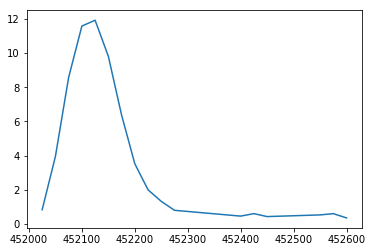

In [58]:
pmf.scan_s12(S1)

In [59]:
PMT_S1 = {}
    
for pmt in P.pmt_active:
    s1_ene, s1_indx = cpf.wfzs(CAL_PMT_MAU[pmt], threshold=0.1)
    PMT_S1[pmt] = cpf.find_S12(s1_ene, s1_indx, **s1par_PMT._asdict())

In [60]:
PMT_S1

{0: {0: [array([ 452550.,  452575.,  452600.,  452625.,  452650.]),
   array([ 0.22628052,  0.34592736,  0.34648008,  0.26750952,  0.14865012])]},
 1: {0: [array([ 452025.,  452050.,  452075.,  452100.,  452125.,  452150.,  452175.]),
   array([ 0.3364862 ,  1.05995439,  1.87495272,  2.14906328,  1.79104689,
           1.02580058,  0.34968376])]},
 2: {0: [array([ 452050.,  452075.,  452100.,  452125.,  452150.,  452175.]),
   array([ 0.11207959,  0.32076486,  0.47033945,  0.56052771,  0.47198494,
           0.29386215])]},
 3: {0: [array([ 452075.,  452100.,  452125.,  452150.,  452175.,  452200.,
           452225.,  452250.,  452275.]),
   array([ 0.24798884,  0.24838559,  0.20687277,  0.24911203,  0.33332792,
           0.45958747,  0.37650031,  0.25136948,  0.16794705])]},
 4: {0: [array([ 452025.,  452050.,  452075.,  452100.,  452125.,  452150.,
           452175.,  452200.,  452225.,  452250.,  452275.]),
   array([ 0.191768  ,  0.70292394,  1.21489706,  1.44904222,  1.26559109

In [64]:
def compare_S1(S1, PMT_S1, peak=0, tol=0.5*units.mus):
    """Compare sum S1 with S1 in individual PMT

    input:
    S1 computed with the sum
    PMT_S1 computed with individual PMTs.
    tol is the matching tolerance.

    Return number of matches

    """
    n_match_s1 = 0
    t = S1[peak][0]
    E = S1[peak][1]
    for pmt in PMT_S1:
        if len (PMT_S1[pmt]) > 0:
            for peak, (t2,E2) in PMT_S1[pmt].items():
                diff = abs(t2[0] - t[0])
                if diff < tol:
                    n_match_s1 +=1
                    break  # if one peak is matched look no further
    return n_match_s1

In [65]:
compare_S1(S1, PMT_S1)

10

In [66]:
s2_par = S12Params(tmin=640*units.mus, tmax=800*units.mus, stride=40, lmin=80, lmax=20000, rebin=True)

In [67]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=0.5)
S2              = cpf.find_S12(s2_ene, s2_indx, **s2_par._asdict())

In [68]:
S2

{0: [array([ 645846.875,  647212.5  ,  648212.5  ,  649212.5  ,  650212.5  ,
          651212.5  ,  652212.5  ,  653212.5  ,  654212.5  ,  655212.5  ,
          656212.5  ,  657212.5  ,  658212.5  ,  659212.5  ,  660212.5  ,
          661302.5  ,  662377.5  ,  663175.   ]),
  array([   43.30301339,   117.76494837,   443.97768957,   886.05093934,
          1449.09190571,  1995.45597669,  2150.02795701,  1773.869474  ,
          1320.54090369,   988.60065926,   666.99944715,   477.02814222,
           408.58801211,   433.90847614,   178.01842817,    88.91538623,
            41.69673622,     5.1321025 ])],
 1: [array([ 673928.125     ,  674962.5       ,  675962.5       ,
          676962.5       ,  677962.5       ,  678962.5       ,
          679962.5       ,  681055.        ,  682013.54166667]),
  array([  59.04695923,  147.3562508 ,  221.32829375,  328.06867352,
          343.1426031 ,  192.0026409 ,  118.68940238,   52.97988203,
           26.22460086])]}

In [80]:
def plot_s12(S12):
    """Plot the peaks of input S12.

    S12 is a dictionary
    S12[i] for i in keys() are the S12 peaks
    """
    plt.figure(figsize=(10, 10))
    mpl.set_plot_labels(xlabel = "t (mus)",
                    ylabel = "S12 (pes)")
    xy = len(S12)
    if xy == 1:
        t = S12[0][0]
        E = S12[0][1]
        ax1 = plt.subplot(1, 1, 1)
        plt.plot(t, E)
    else:
        x = 3
        y = xy/x
        if y % xy != 0:
            y = int(xy/x) + 1
        for i in S12.keys():
            ax1 =  plt.subplot(x, y, i+1)
            t = S12[i][0]
            E = S12[i][1]
            plt.plot(t, E)


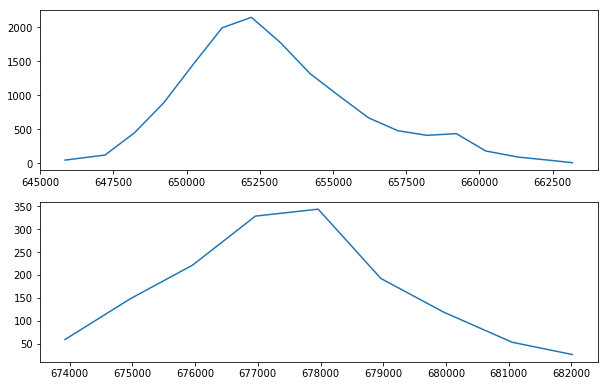

In [81]:
plot_s12(S2)

number of peaks = 2
S12 number = 0, samples = 18 sum in pes =13468.970197785615
S12 number = 1, samples = 9 sum in pes =1488.8393065801442


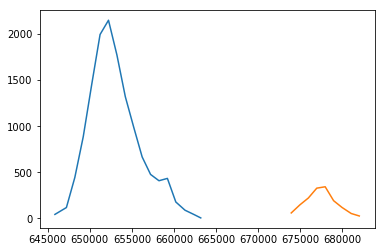

In [82]:
pmf.scan_s12(S2)

In [83]:
sipm = cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm, thr=3.5*units.pes, n_MAU=100)
SIPM = cpf.select_sipm(sipm)
S2Si = pf.sipm_s2_dict(SIPM, S2, thr=30*units.pes)

In [84]:
S2Si

{0: {1099: array([ 0.        ,  0.        ,  0.        ,  0.        ,  6.20799183,
          8.33144323,  8.87747359,  5.84397159,  3.90253031,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ]),
  1108: array([  0.        ,   0.        ,   0.        ,   5.49277528,
          14.31484516,  11.86427019,  12.53817831,  11.06783333,
           8.18840774,   4.45128092,   5.18645341,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ]),
  1109: array([  0.        ,   0.        ,   0.        ,   0.        ,
           3.64210021,   9.04231245,  12.49593656,   9.35627828,
           5.21192935,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ]),
  1112: array([  0.        ,   0.        ,   4.34757044,  10.7684499

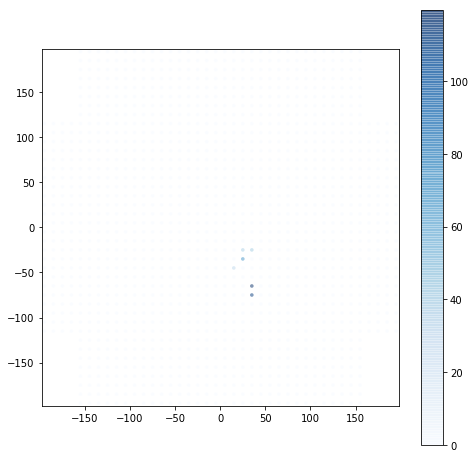

In [85]:
pmf.plot_s2si_map(S2Si)